In [15]:
cd /Users/joepalmo/Desktop/cfa/SDU-preproc

/Users/joepalmo/Desktop/cfa/SDU-preproc


In [153]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.io import fits
import os

# open source module found for converting MJD/JD to DateTimes
import jdutil as jd

# Ben's module -- THANKS BEN
import LCtools

# my preprocessing module
from preproc import *

import glob

In [140]:
# specify path to the lightcurve and spectrum
lc_path = "RCorBor/aavsodata_61f41f7ecd110.txt"
spec_path = "RCorBor/0142.RCorBor.ms.fits"

# object name (or abbreviation)
n = "RCorBor"

# resample length for time-sorted LC purposes
resample_len = '14d'

# LC Data Munging

In [141]:
# read in the text file
lc = pd.read_csv(lc_path, sep = ",")

/Users/joepalmo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,7,8,9,12,14,20,21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [142]:
lc['Magnitude'] = pd.to_numeric(lc['Magnitude'], errors='coerce')

In [143]:
lc = lc[lc['Band'] == 'Vis.']

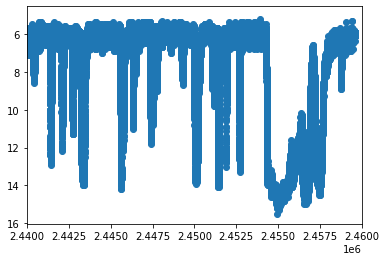

In [144]:
#raw data
plt.scatter(lc['JD'], lc['Magnitude'])
plt.xlim(2.44e6, 2.46e6)
plt.gca().invert_yaxis()

In [145]:
df = pd.DataFrame(list(zip(lc['JD'], lc['Magnitude'])), columns=['jd', 'mag'])

In [146]:
df = df[df['jd'].between(2.4525e6, 2.46e6)]

In [147]:
df['mjd'] = jd.jd_to_mjd(df['jd'])

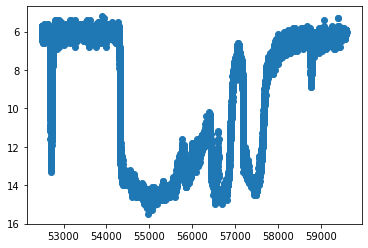

In [148]:
#raw data
plt.scatter(df['mjd'], df['mag'])
plt.gca().invert_yaxis()

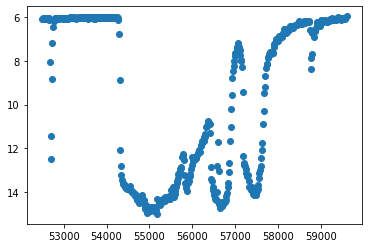

In [149]:
#resampled data
time_preproc_lc = LC_timesort_preproc(df, resample_len=resample_len)
plt.scatter(time_preproc_lc['Modified Julian Day'], time_preproc_lc['Magnitude'])
plt.gca().invert_yaxis()

In [150]:
# number of days video covers
len(time_preproc_lc.dropna())

499

In [151]:
len(time_preproc_lc)

508

In [152]:
# The average data play rate determined empirically from sonoUno is about 
# 8.5 data rows played per second. Therefore:
print("Estimated video time of "+ str(len(time_preproc_lc) / 8.5), "s")

Estimated video time of 59.76470588235294 s


# Spectra Data Munging

In [167]:
spec = fits.open(spec_path)

In [168]:
spec[0].header

 [astropy.io.fits.verify]


SIMPLE  =                    T                                                  
BITPIX  =                  -32 / IRAF .imh pixel type                           
NAXIS   =                    3 / IRAF .imh naxis                                
NAXIS1  =                 2635 / IRAF .imh naxis[1]                             
NAXIS2  =                    1 / IRAF .imh naxis[2]                             
NAXIS3  =                    4 / IRAF .imh naxis[3]                             
OBJECT  = 'RCorBor '           / IRAF .imh title                                
IRAF-MAX=           0.000000E0  /  DATA MAX                                     
IRAF-MIN=           0.000000E0  /  DATA MIN                                     
RA      = '15:48:34.00'         /  MEAN RA                                      
DEC     = '28:09:25.00'         /  MEAN DEC                                     
EPOCH   = 2000                 /MEAN EPOCH                                      
RRA     = '15:48:34'        

In [170]:
wvl = ((np.arange(spec[0].header['NAXIS1']) + 1.0) - spec[0].header['CRPIX1']) * spec[0].header['CD1_1'] + spec[0].header['CRVAL1']

In [180]:
spec[0].data[3][0]

18.197477

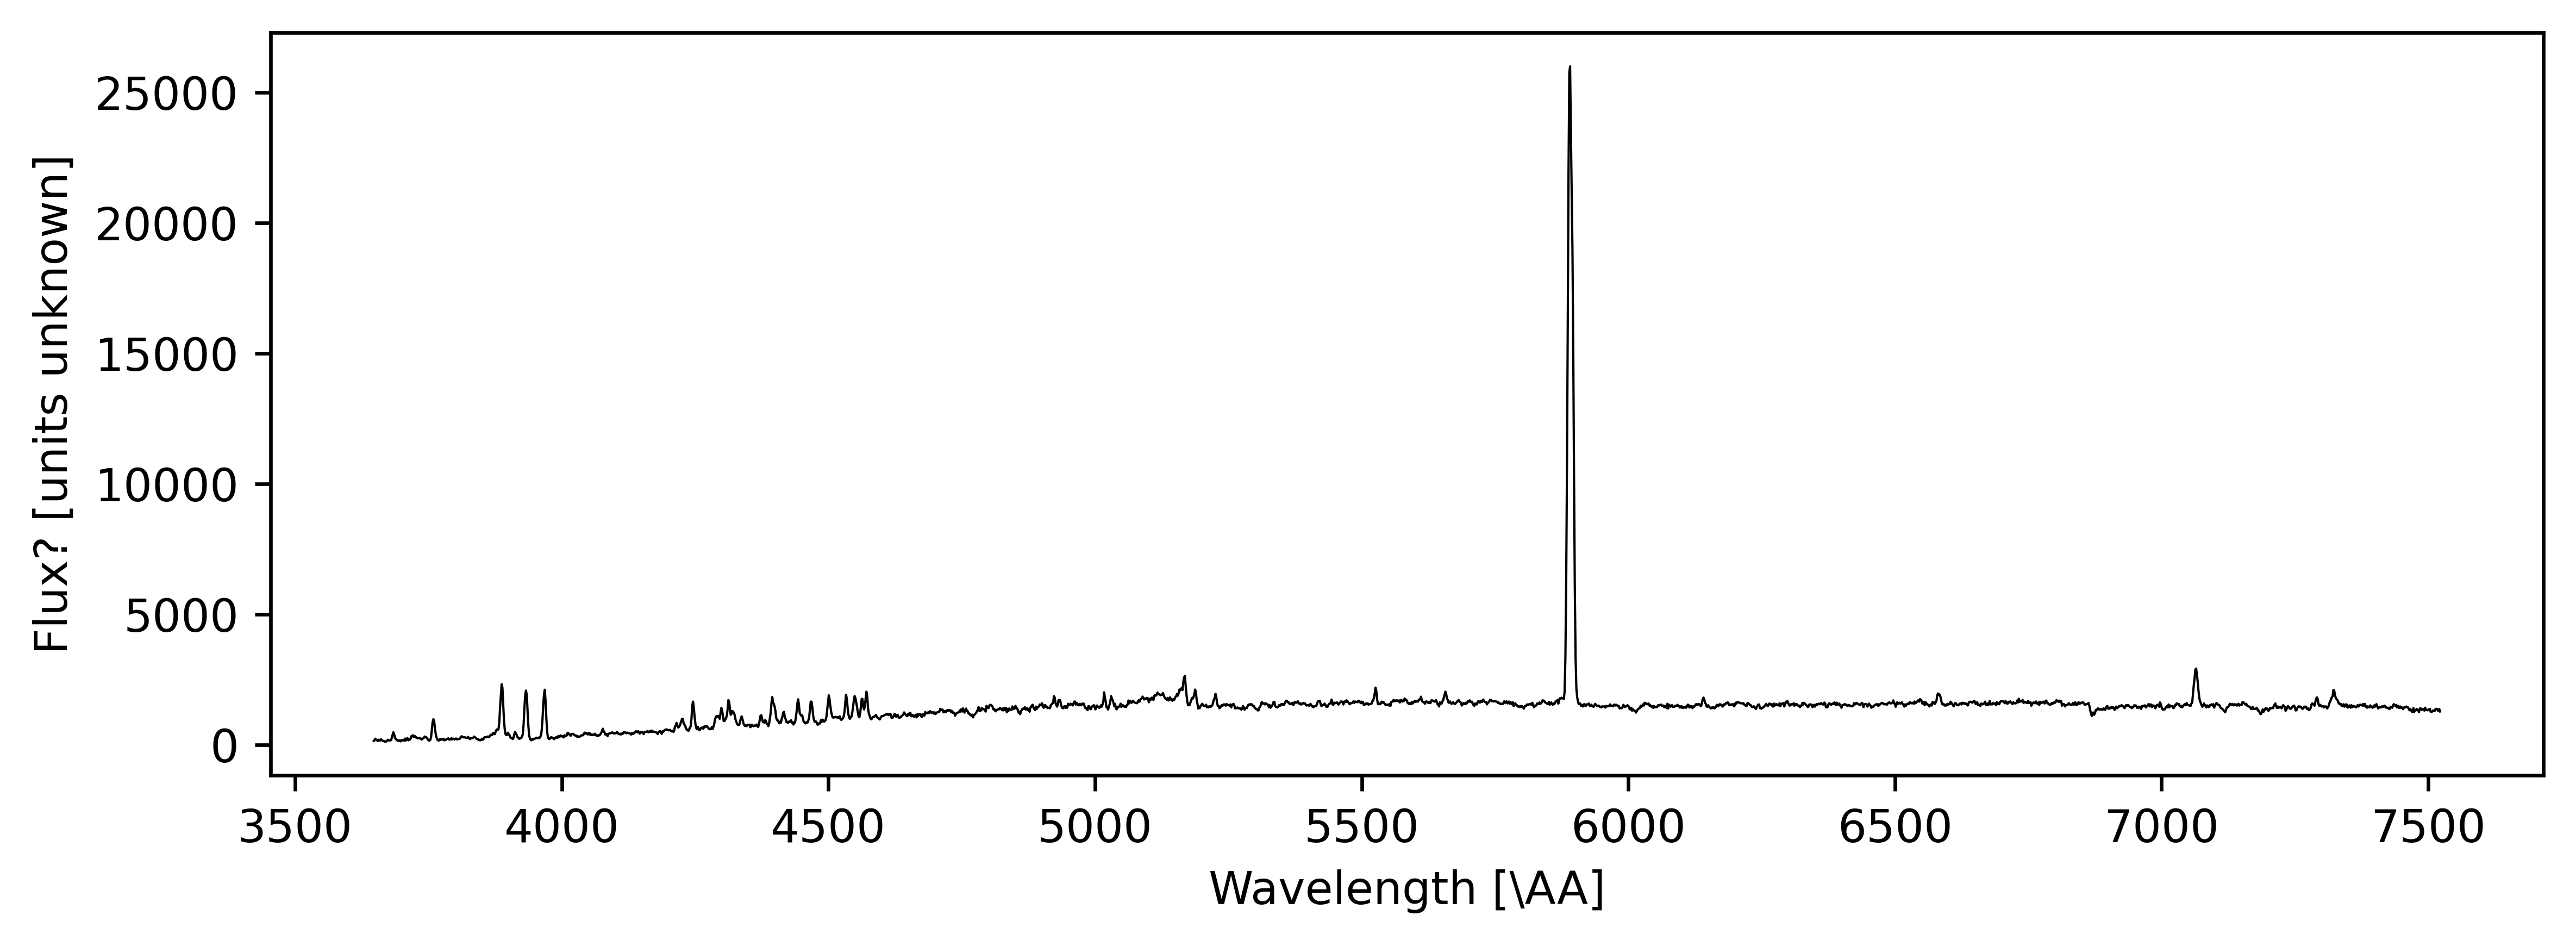

In [187]:
fig = plt.figure(figsize=(8,3), dpi=600)
ax = plt.gca()

ax.plot(wvl, spec[0].data[0,0, :], lw=0.5, c='k')

ax.set_xlabel("Wavelength [\AA]")
ax.set_ylabel("Flux? [units unknown]")

plt.tight_layout()

In [228]:
spec_df = pd.DataFrame(list(zip(wvl, spec[0].data[0,0, :])),
               columns =['wavelength', 'flux'])

In [229]:
#spec_df[(spec_df['wavelength'] > 5540) & (spec_df['wavelength'] < 5595)]
spec_df.loc[(spec_df['flux'] > 3000), 'flux'] = 1500

In [230]:
preproc_spec = spectra_preproc(spec_df, bins=np.arange(3800,7200,15))

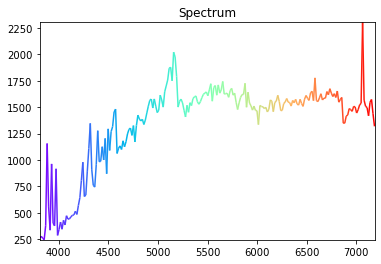

In [231]:
#preprocessed
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = preproc_spec['Wavelength'], preproc_spec['Flux']
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Spectrum')
plt.show()

In [232]:
# rescale to remove scientific notation
preproc_spec['Flux'] = preproc_spec['Flux'] / 1000

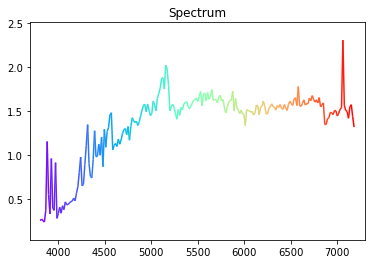

In [233]:
#preprocessed
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
fig, ax = plt.subplots()
x,y = preproc_spec['Wavelength'], preproc_spec['Flux']
ax.set_xlim(3700, 7300)
ax.set_ylim(np.nanmin(y)-0.5*np.nanstd(y), np.nanmax(y)+0.5*np.nanstd(y))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# Create a continuous norm to map from data points to colors
norm = plt.Normalize(x.min(), x.max())
lc = LineCollection(segments, cmap='rainbow', norm=norm)
lc.set_array(x)
ax.add_collection(lc)
ax.set_title('Spectrum')
plt.show()

In [234]:
len(preproc_spec) / 8.5

26.58823529411765

# Export Preprocessed Files

In [235]:
#create output directory
outdir = 'preproc/{}/'.format(n)
if not os.path.exists(outdir):
    os.makedirs(outdir)   

In [236]:
#save preprocessed files
time_preproc_lc.to_csv("preproc/{}/{}_LC_timesort.csv".format(n,n), index=False)
preproc_spec.to_csv("preproc/{}/{}_spec.csv".format(n,n), index=False)